In [5]:
'''
Knowledge Graphs and Node Classification
We have one large graph and not many individual graphs (like molecules)
We infere on unlabeled nodes in this large graph and hence perform node-level predictions 
 
The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. 
The dictionary consists of 1433 unique words.(bag of words representation)
node = publication, edge = citation, node feature = word vector, label = publication topic ( 7 topics in this dataset )
'''

'\nKnowledge Graphs and Node Classification\nWe have one large graph and not many individual graphs (like molecules)\nWe infere on unlabeled nodes in this large graph and hence perform node-level predictions \n \nThe Cora dataset consists of 2708 scientific publications classified into one of seven classes.\nEach publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. \nThe dictionary consists of 1433 unique words.(bag of words representation)\nnode = publication, edge = citation, node feature = word vector, label = publication topic ( 7 topics in this dataset )\n'

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [2]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(50*'=')

data = dataset[0]  

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [3]:
print(data.x.shape) # [Num_Nodes x Features]

data.x[0][:50] # first 50 entries (normalized word count)

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [4]:
data.y #labels

tensor([3, 4, 4,  ..., 3, 3, 3])

In [5]:
# masking of nodes for training and testing
print(data.test_mask)
print(data.train_mask)

tensor([False, False, False,  ...,  True,  True,  True])
tensor([ True,  True,  True,  ..., False, False, False])


In [6]:
#edges
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [25]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv 

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=8)
        self.conv3 = GCNConv(hidden_channels*8, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GNN(hidden_channels=16)
print(model)
print("number of parameters: ", sum(p.numel() for p in model.parameters()))

GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GATConv(16, 16, heads=8)
  (conv3): GCNConv(128, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)
number of parameters:  27559


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

In [27]:
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 2000

In [28]:
def train():
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
for epoch in range(num_epochs):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9460
Epoch: 100, Loss: 1.7943
Epoch: 200, Loss: 1.6709
Epoch: 300, Loss: 1.5975
Epoch: 400, Loss: 1.4100
Epoch: 500, Loss: 1.3241
Epoch: 600, Loss: 1.2922
Epoch: 700, Loss: 1.2809
Epoch: 800, Loss: 1.3042
Epoch: 900, Loss: 1.2667
Epoch: 1000, Loss: 1.2569
Epoch: 1100, Loss: 1.2608
Epoch: 1200, Loss: 1.2880
Epoch: 1300, Loss: 1.2695
Epoch: 1400, Loss: 1.2948
Epoch: 1500, Loss: 1.2502
Epoch: 1600, Loss: 1.2481
Epoch: 1700, Loss: 1.2649
Epoch: 1800, Loss: 1.2530
Epoch: 1900, Loss: 1.2617


<Axes: >

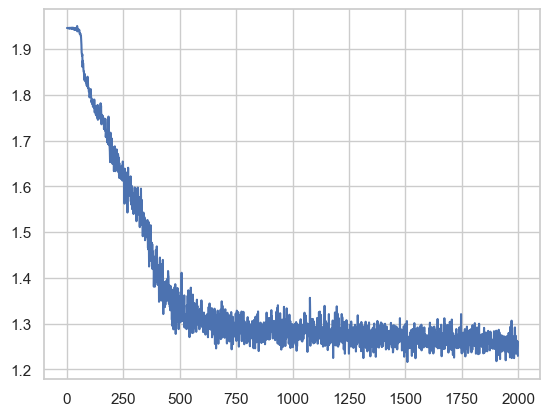

In [29]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

In [30]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7500


torch.Size([2708, 7])


<Axes: >

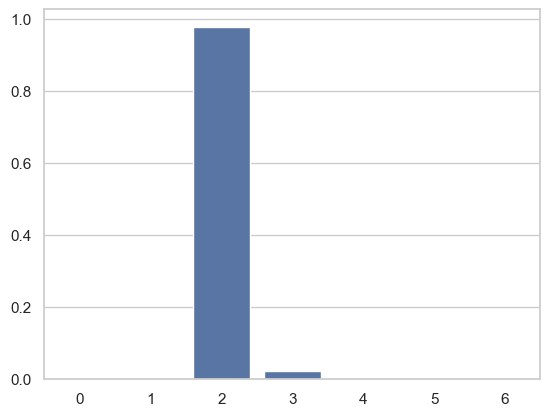

In [31]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [32]:
# visulizaing the learnt embedding

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    arr = plt2arr(fig)
    plt.close(fig)  # Close the figure to prevent display
    return arr


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [33]:
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

TSNE Visualization finished.


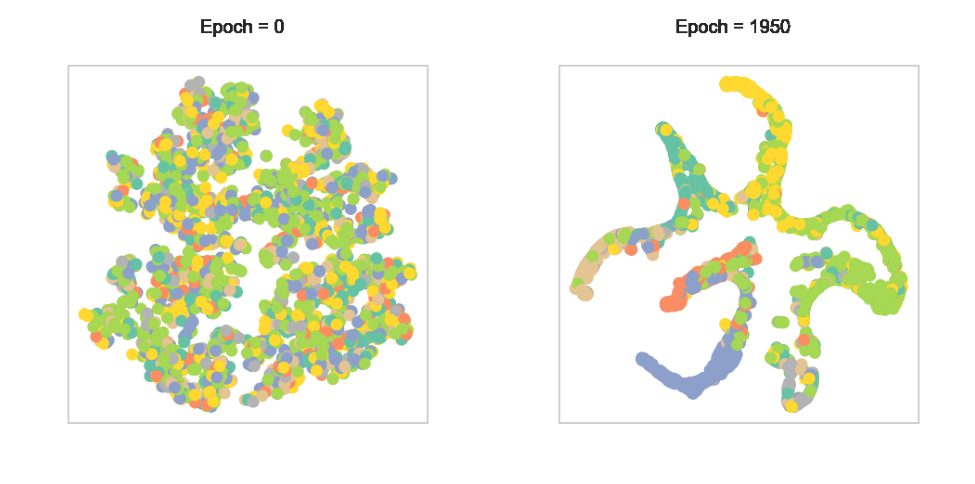

In [46]:
import matplotlib.pyplot as plt

def display_first_and_last(images):
    if not images:
        print("The images list is empty.")
        return
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  
    first_image = images[0]
    axs[0].imshow(first_image)
    axs[0].axis('off')  # Hide the axis
   
    last_image = images[-1]
    axs[1].imshow(last_image)
    axs[1].axis('off')  # Hide the axis
 
    plt.tight_layout()
    plt.show()

# Example usage
display_first_and_last(images)

MoviePy - Building file tsne_visualization.gif with imageio.


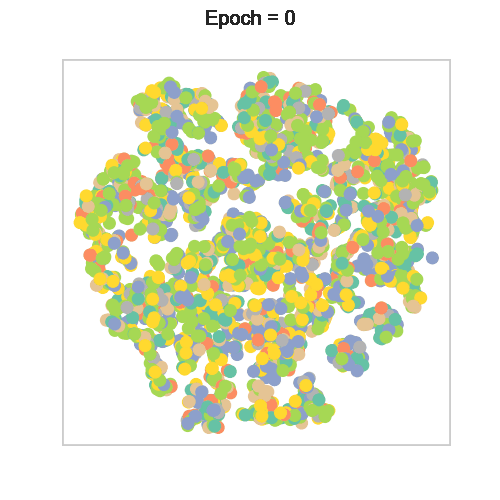

In [74]:
from moviepy.editor import ImageSequenceClip
from IPython.display import Image, display

clip = ImageSequenceClip(images, fps=1)  # Adjust FPS as needed
gif_path = 'tsne_visualization.gif'
clip.write_gif(gif_path, fps=1)

# Display the GIF in the notebook
display(Image(filename=gif_path))